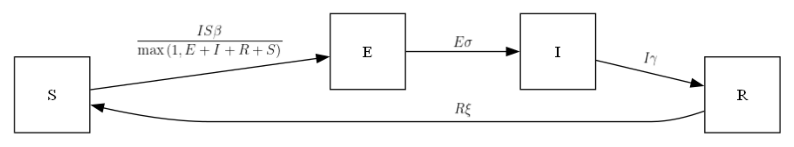

In [1]:
from epymorph.parameter_fitting.filter.particle_filter import ParticleFilter
from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation
from epymorph.time import TimeFrame
import numpy as np

from epymorph import *  # noqa: F403
from epymorph.adrio import acs5, commuting_flows
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.seirs import Seirs
from epymorph.data.mm.pei import Pei
from epymorph.rume import SingleStrataRume

from epymorph.initializer import Explicit

scope = StateScope.in_states(["AZ", "CO", "NM", "UT"], year=2015)
n_nodes = len(scope.includes)
initial_state = np.zeros(shape=(n_nodes, 4), dtype=np.int64)
initial_state[:, 0] = 100_000 - 10
initial_state[:, 1] = 20

duration = 120

t = np.arange(0, duration)
beta = 0.5 * np.exp(-0.1 * np.maximum(t - 20, 0)) + 0.1

rume = SingleStrataRume.build(
    # Load an IPM from the library
    ipm=Seirs(),
    # Load an MM from the library
    mm=Pei(),
    # Use our scope
    scope=scope,
    init=Explicit(initials=initial_state),
    # Set the time-frame to simulate
    time_frame=TimeFrame.of("2015-01-01", duration),
    # Provide parameter values
    params={
        "beta": beta,
        "sigma": 1 / 7,
        "gamma": 1 / 14,
        "xi": 0,
        # Geographic data can be loaded using ADRIOs
        "population": acs5.Population(),
        "commuters": commuting_flows.Commuters(),
    },
)

rume.ipm.diagram()

In [2]:
initial_state

array([[99990,    20,     0,     0],
       [99990,    20,     0,     0],
       [99990,    20,     0,     0],
       [99990,    20,     0,     0]], dtype=int64)

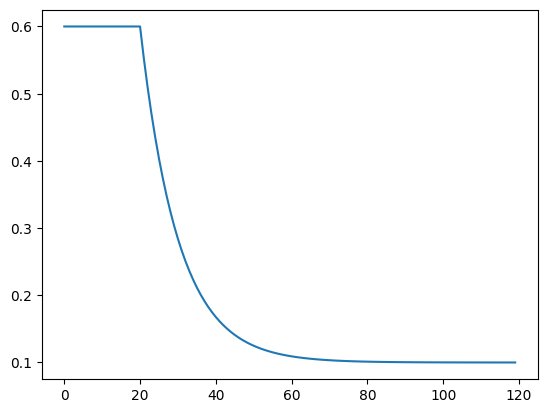

In [3]:
import matplotlib.pyplot as plt


plt.plot(t, beta)


In [4]:
from epymorph.log.messaging import sim_messaging
from epymorph.simulator.basic.basic_simulator import BasicSimulator

rng = np.random.default_rng(seed=1)

sim = BasicSimulator(rume)
with sim_messaging():
    out = sim.run(rng_factory=(lambda: rng))

Loading gpm:all::mm::commuters (epymorph.adrio.commuting_flows.Commuters):
  |####################| 100%  (7.287s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-04-30 (120 days)
• 4 geo nodes
  |####################| 100%                     
Runtime: 0.094s


In [5]:
from epymorph.time import ByDate
from epymorph.tools.data import munge

cases_df = munge(
    out,
    quantity=rume.ipm.select.events("E->I"),
    time=rume.time_frame.select.all().group(ByDate()).agg(),
    geo=rume.scope.select.all(),
)

In [6]:
cases_df.to_csv("./doc/devlog/data/temp_synthetic_data.csv", index=False)

In [7]:
from pathlib import Path
from epymorph.adrio import acs5, csv

csvadrio = csv.CSVTimeSeries(
    file_path=Path("./doc/devlog/data/temp_synthetic_data.csv"),
    time_col=0,
    time_frame=rume.time_frame,
    key_col=1,
    data_col=2,
    data_type=int,
    key_type="geoid",
    skiprows=1,
)

In [8]:
import dataclasses
from epymorph.attribute import AbsoluteName, NamePattern

name = AbsoluteName(strata="gpm:all", module="mm", id="commuters")
attr_def = rume.requirements[name]

dr = rume.evaluate_params(rng=rng)
commuter_matrix = dr.resolve(name, attr_def)

params_copy = dict(rume.params)
params_copy[NamePattern(strata="*", module="*", id="commuters")] = commuter_matrix

rume_copy = dataclasses.replace(rume, params=params_copy)

In [9]:
from epymorph.parameter_fitting.likelihood import Poisson
from epymorph.parameter_fitting.utils.observations import ModelLink, Observations
from epymorph.parameter_fitting.utils.resampler import ResamplingByNode

observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        quantity=rume.ipm.select.events("E->I"),
        time=rume.time_frame.select.all().group(ByDate()).agg(),
        geo=rume.scope.select.all(),
    ),
    likelihood=Poisson(),
)

filter_type = ParticleFilter(num_particles=500, resampler=ResamplingByNode)

In [10]:
from epymorph.parameter_fitting.distribution import Uniform
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters
from epymorph.parameter_fitting.dynamics import (
    GeometricBrownianMotion,
)

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.1, b=0.8),
        dynamics=GeometricBrownianMotion(volatility=0.1),
    ),
}

In [11]:
sim = FilterSimulation(
    rume=rume_copy,
    observations=observations,
    filter_type=filter_type,
    params_space=params_space,
)

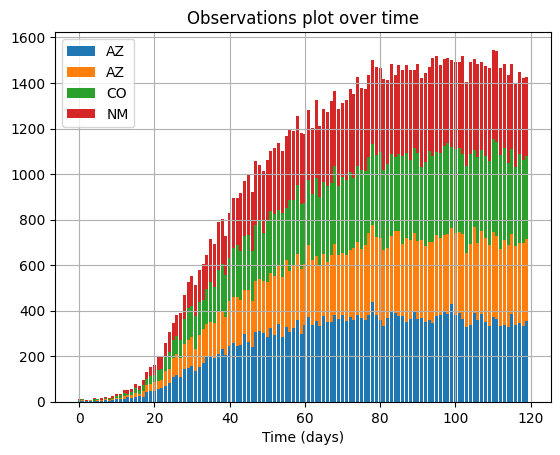

In [12]:
time_axis = range(len(sim.cases))

plt.bar(time_axis, sim.cases[:, 0], label=rume.scope.labels[0])
n_nodes = sim.cases.shape[1]
for i_node in range(n_nodes - 1):
    plt.bar(
        time_axis,
        sim.cases[:, i_node + 1],
        bottom=sim.cases[:, 0 : i_node + 1].sum(axis=1),
        label=rume.scope.labels[i_node],
    )

plt.title("Observations plot over time")
plt.grid(True)
plt.xlabel("Time (days)")
plt.legend()
plt.show()


In [13]:
output = sim.run()

Running Particle Filter simulation
• 2015-01-01 00:00:00 to 2015-04-30 00:00:00 (120 days)
• 500 particles

Simulation completed in 331.77s

Parameters estimated: ['beta']


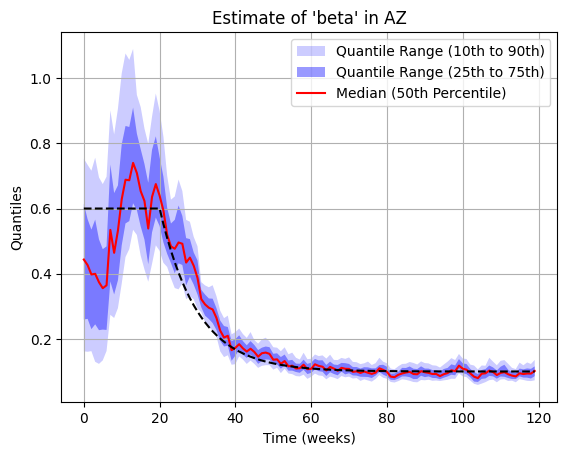

In [14]:
key = "beta"
node_index = 0
truth = None

key_quantiles = np.array(output.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)

obs = np.arange(0, len(key_quantiles))
plt.plot(obs, np.broadcast_to(beta, shape=obs.shape), "k--")

plt.title(f"Estimate of '{key}' in {rume.scope.labels[node_index]}")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

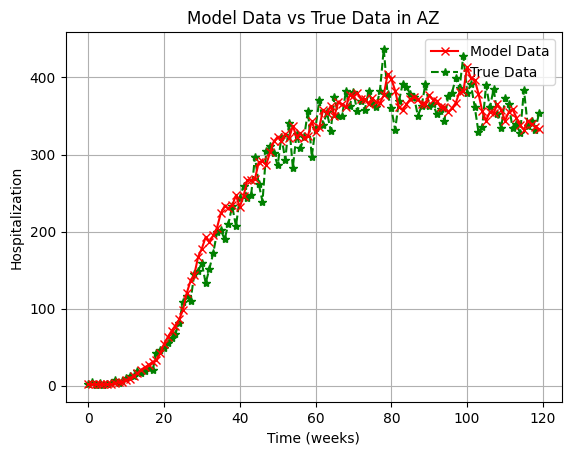

In [15]:
node_index = 0

plt.plot(
    output.model_data[:, 0],
    label="Model Data",
    color="red",
    linestyle="-",
    zorder=10,
    marker="x",
)

plt.plot(
    output.true_data[:, 0],
    label="True Data",
    color="green",
    linestyle="--",
    zorder=9,
    marker="*",
)

plt.xlabel("Time (weeks)")
plt.ylabel("Hospitalization")
plt.title(f"Model Data vs True Data in {rume.scope.labels[node_index]}")
plt.legend(loc="upper right")
plt.grid(True)

plt.show()
